# Dependencies 

In [287]:
# Standard 
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import time

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Import clean data

In [288]:
# Time start
start = time.time()

# Load csv-file and display 5 first rows
data = pd.read_csv("clean.csv", sep = ",", index_col="Unnamed: 0")
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0


# Data for RandomForestClassifier

In [289]:
forest_data = data.copy()

X = forest_data.drop(["Outcome"], axis = 1)
y = forest_data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777, stratify=y, test_size=0.2)

# Hyperparameter tuning for RandomForestClassifier

### Tuning process:
1. Hyperparameters are initially tuned using RandomizedSearchCV, and their performance are visualized.
2. The performance of the best RandomizedSearchCV model is analyzed and visualized.
3. Hyperparameter intervals for GridSearchCV are selected based on thier performance (measured by recall)
4. The performance of the best GridSearchCV model is visualized.

### Performance metric
The goal of the model is to classify whether a person has diabetes from 8 features. Given the medical context, recall is used as scoring metric. 

The choice of recall is motivated by the fact that it is more critical to identify diabetic patients (true positives) than to avoid false positives. Misclassifying a diabetic person as healthy could have serious consequences, whereas misclassifying a healthy patient as diabetic primarly leads to more medical evaluation.

In [290]:
# Recall scorer for tuning
scorer = make_scorer(recall_score)

### Hyperparameters for RandomizedSearchCV

In [291]:
random_search_params = {
    "max_depth": list(range(3, 30 + 1)), 
    "min_samples_leaf": list(range(2, 20 + 1)),
    "n_estimators": list(range(5, 500 + 1)),
    "max_features": list(range(1, len(X.columns) + 1))
          }

### Randomized search

In [292]:
rand_cv_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(criterion="entropy", random_state=777),
    n_iter=50,
    param_distributions=random_search_params,
    n_jobs=8,
    refit="recall",
    verbose=0,
    cv = 5,
    random_state=777,
    return_train_score=True,
    scoring=scorer
    )

### Fit training data to RandomizedSearchCV

In [293]:
rand_cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    random_state=777),
                   n_iter=50, n_jobs=8,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, 15, 16,
                                                      17, 18, 19, 20, 21, 22,
                                                      23, 24, 25, 26, 27, 28,
                                                      29, 30],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7,
                                                         8],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 14, 15, 16, 17,
                                                         18, 19, 20, 21, 22, 23,
                                                         24, 25, 26, 27, 28, 29,
                                                         30, 31, 32, 33, 34, ...]},
                   random_state=777, refit='recall', return_train_score=True,
                   scoring=make_scorer(recall_score, response_method='predict'))

### Save data from fitting

In [294]:
rand1_df = pd.DataFrame(rand_cv_rf.cv_results_)

### Predictions from the best RandomizedSearchCV model

In [295]:
random_search_predictions = rand_cv_rf.predict(X_test)

### Confusion matrix (RandomizedSearchCV)

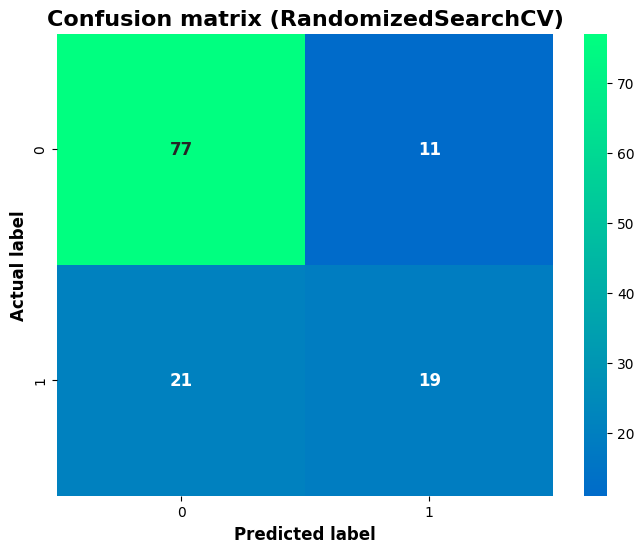

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        88
           1       0.63      0.47      0.54        40

    accuracy                           0.75       128
   macro avg       0.71      0.68      0.69       128
weighted avg       0.74      0.75      0.74       128



In [296]:
fig, ax = plt.subplots(figsize = (8, 6))
cm = confusion_matrix(y_true=y_test, y_pred=random_search_predictions)
sns.heatmap(
    data = cm, 
    cmap="winter", 
    center = 20, 
    annot=True, 
    annot_kws = {
        "fontsize":12, 
        "fontweight":"bold"
        },
    ax = ax
    )
plt.title(
    "Confusion matrix (RandomizedSearchCV)",
    fontsize = 16,
    fontweight = "bold"
    )
plt.xlabel(
    "Predicted label",
    fontsize = 12,
    fontweight = "bold"
    )
plt.ylabel(
    "Actual label",
    fontsize = 12,
    fontweight = "bold"
    )
fig.savefig("RandomizedSearchCV_RFC_ConfusionMatrix.png")
plt.show()

# Report
print(classification_report(y_test, random_search_predictions))

### Visualize performance for each hyperparameter

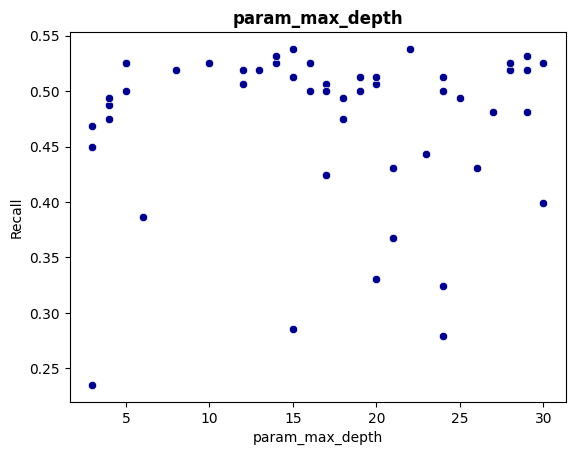

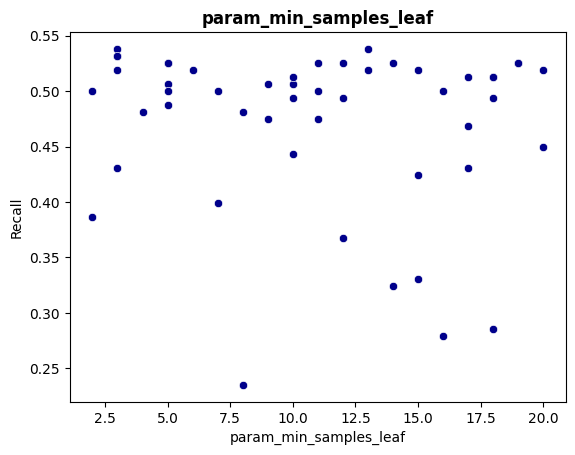

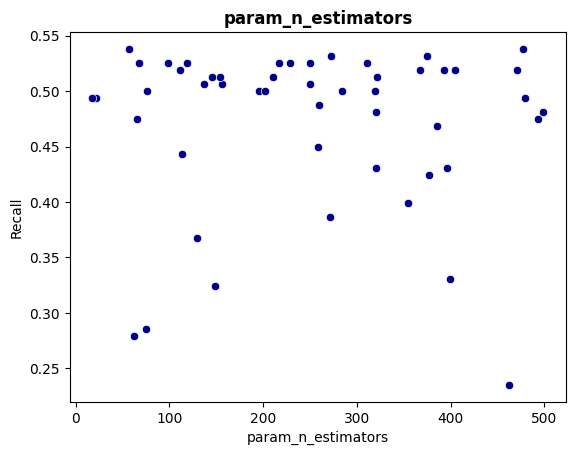

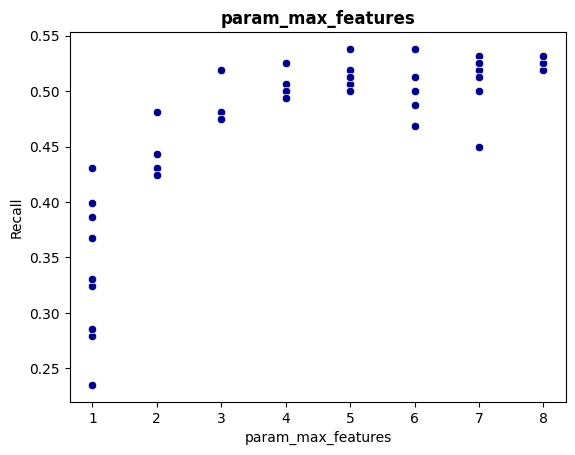

In [297]:
rand1_columns = ["param_max_depth", "param_min_samples_leaf", "param_n_estimators", "param_max_features"]

# Plot for each hyperparameter
for col in rand1_columns:
    plt.title(f'{col}', fontsize = 12, fontweight = "bold")
    sns.scatterplot(data = rand1_df, x = col, y = rand1_df["mean_test_score"], c = "darkblue")
    plt.xlabel(f'{col}', fontsize = 10)
    plt.ylabel(f'Recall', fontsize = 10)
    plt.show()

### Grid search
Hyperparameter intervals are selected as following:
- "max_depth": 5, 7, 9
- "min_samples_leaf": 3, 5
- "n_estimators": 80, 90 (recall score do not increase with more estimators)
- "max_features": 5, 7

In [298]:
grid_search_params = {
    "max_depth" : [5, 7, 9],
    "min_samples_leaf" : [3, 5],
    "n_estimators" : [80, 90],
    "max_features" : [5, 7]
}

### Grid Search

In [299]:
grid_cv_rf = GridSearchCV(
    estimator=RandomForestClassifier(criterion="entropy", random_state=777),
    param_grid=grid_search_params,
    n_jobs=8,
    refit="recall",
    verbose=0,
    cv = 5,
    return_train_score=True,
    scoring=scorer
    )

### Fit training data to GridSearchCV

In [300]:
grid_cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=777),
             n_jobs=8,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [5, 7],
                         'min_samples_leaf': [3, 5], 'n_estimators': [80, 90]},
             refit='recall', return_train_score=True,
             scoring=make_scorer(recall_score, response_method='predict'))

### Predictions from the best GridSearchCV model

In [301]:
grid_search_predictions = grid_cv_rf.predict(X_test)

### Confusion matrix (GridSearchCV)

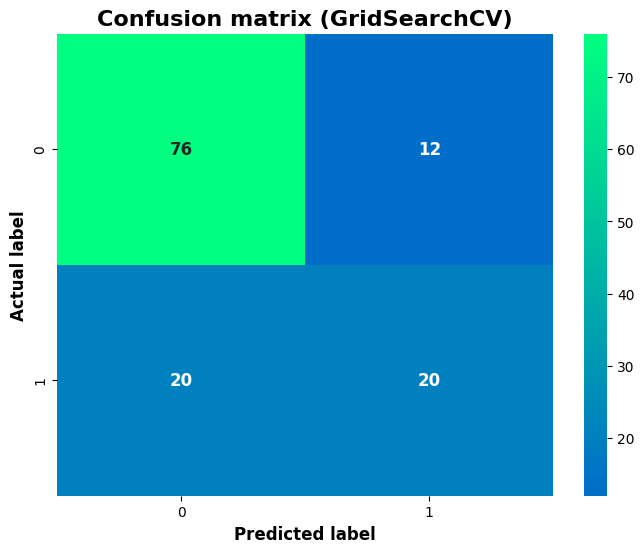

              precision    recall  f1-score   support

           0       0.79      0.86      0.83        88
           1       0.62      0.50      0.56        40

    accuracy                           0.75       128
   macro avg       0.71      0.68      0.69       128
weighted avg       0.74      0.75      0.74       128



In [302]:
fig, ax = plt.subplots(figsize = (8, 6))
cm = confusion_matrix(y_true=y_test, y_pred=grid_search_predictions)
sns.heatmap(
    data = cm, 
    cmap="winter", 
    center = 20, 
    annot=True, 
    annot_kws = {
        "fontsize":12, 
        "fontweight":"bold"
        },
    ax = ax
    )
plt.title(
    "Confusion matrix (GridSearchCV)",
    fontsize = 16,
    fontweight = "bold"
    )
plt.xlabel(
    "Predicted label",
    fontsize = 12,
    fontweight = "bold"
    )
plt.ylabel(
    "Actual label",
    fontsize = 12,
    fontweight = "bold"
    )
fig.savefig("GridSearch_RFC_ConfusionMatrix.png")
plt.show()

# Report
print(classification_report(y_test, grid_search_predictions))

# Runtime

In [303]:
# Time end and total time
end = time.time()

# Total runtime
print(f'Total runtime: {end-start:.3f} s')

Total runtime: 8.262 s
